# Import

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

# Load Files

In [3]:
# Load File
DATA_PATH = Path('../../Data/')
data = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.expression.txt'), sep = '\t').fillna("NaN")
metadata = pd.read_csv(Path(DATA_PATH, 'Original/TCGA.HNSC.metadata.txt'), sep = '\t').fillna("NaN")

# QC

In [5]:
data = data.drop(columns="patient_id")
data = data.set_index("sample_id")

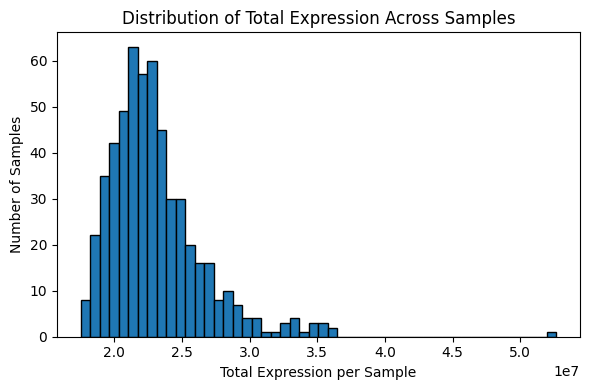

0 samples below threshold


In [8]:
# Sum of expression values per sample (row-wise)
total_reads = data.sum(axis=1)

# Plot histogram
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.hist(total_reads, bins=50, edgecolor='black')
plt.xlabel("Total Expression per Sample")
plt.ylabel("Number of Samples")
plt.title("Distribution of Total Expression Across Samples")
plt.tight_layout()
plt.show()

low_quality = total_reads[total_reads < 1e7]  # under 10 million
print(f"{len(low_quality)} samples below threshold")

# Metadata Exploration
* with the aid of chatgpt

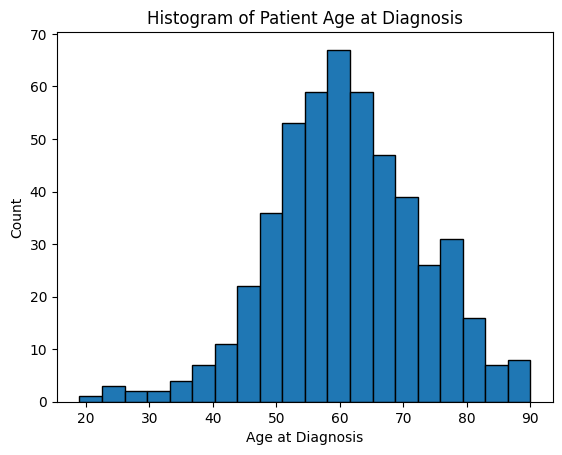

In [6]:
import matplotlib.pyplot as plt
plt.hist(metadata.age_at_initial_pathologic_diagnosis.dropna(), bins=20, edgecolor='black')
plt.xlabel('Age at Diagnosis')
plt.ylabel('Count')
plt.title('Histogram of Patient Age at Diagnosis')
plt.show()

In [8]:
from scipy import stats

# Drop NA values
ages = metadata.age_at_initial_pathologic_diagnosis.dropna()

# D’Agostino and Pearson’s test
normaltest_stat, normaltest_p = stats.normaltest(ages)
print(f"D’Agostino and Pearson’s test: p = {normaltest_p:.4f}")


D’Agostino and Pearson’s test: p = 0.1003


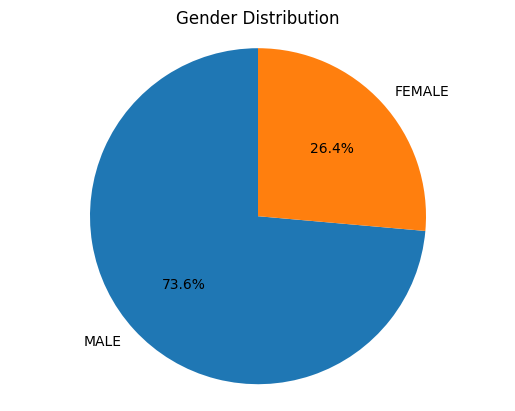

In [9]:
gender_counts = metadata.gender.value_counts()
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

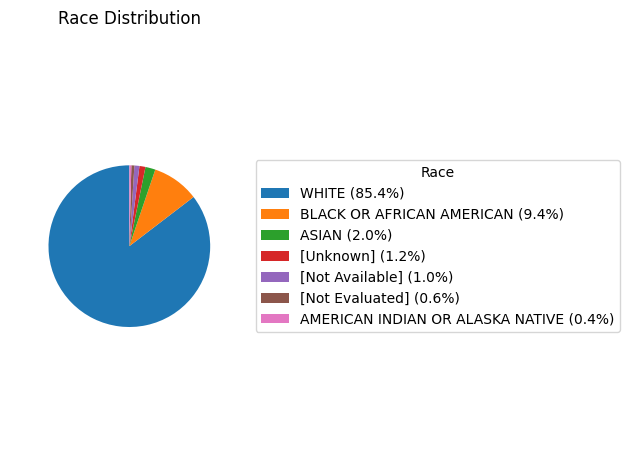

In [10]:
fig, ax = plt.subplots()

# Create the pie chart without labels inside
wedges, texts = ax.pie(
    race_counts,
    startangle=90
)

# Add external legend with labels and percentages
percentages = (race_counts / race_counts.sum() * 100).round(1).astype(str) + '%'
labels_with_pct = [f"{label} ({pct})" for label, pct in zip(race_counts.index, percentages)]

ax.legend(wedges, labels_with_pct, title="Race", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('Race Distribution')
ax.axis('equal')

plt.tight_layout()
plt.show()

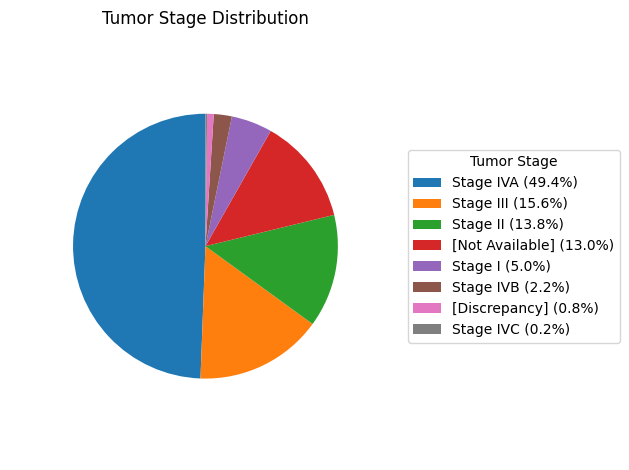

Stage IVA: 247 samples (49.4%)
Stage III: 78 samples (15.6%)
Stage II: 69 samples (13.8%)
[Not Available]: 65 samples (13.0%)
Stage I: 25 samples (5.0%)
Stage IVB: 11 samples (2.2%)
[Discrepancy]: 4 samples (0.8%)
Stage IVC: 1 samples (0.2%)


In [10]:
# Count and clean up tumor stage values
stage_counts = metadata.ajcc_pathologic_tumor_stage.dropna().value_counts()

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts = ax.pie(
    stage_counts,
    startangle=90
)

# Add legend with labels + percentages
percentages = (stage_counts / stage_counts.sum() * 100).round(1).astype(str) + '%'
labels_with_pct = [f"{label} ({pct})" for label, pct in zip(stage_counts.index, percentages)]

ax.legend(wedges, labels_with_pct, title="Tumor Stage", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('Tumor Stage Distribution')
ax.axis('equal')

plt.tight_layout()
plt.show()
for stage, count in stage_counts.items():
    pct = (count / stage_counts.sum()) * 100
    print(f"{stage}: {count} samples ({pct:.1f}%)")

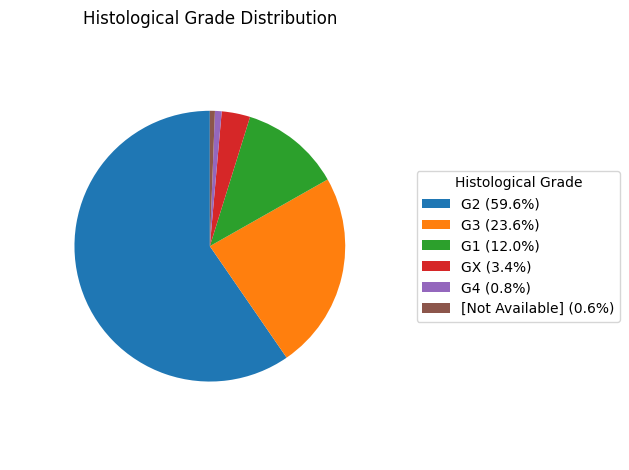

In [12]:
# Count and clean histological grade values
grade_counts = metadata.histological_grade.dropna().value_counts()

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts = ax.pie(
    grade_counts,
    startangle=90
)

# Add legend with labels + percentages
percentages = (grade_counts / grade_counts.sum() * 100).round(1).astype(str) + '%'
labels_with_pct = [f"{label} ({pct})" for label, pct in zip(grade_counts.index, percentages)]

ax.legend(wedges, labels_with_pct, title="Histological Grade", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('Histological Grade Distribution')
ax.axis('equal')

plt.tight_layout()
plt.show()


In [13]:
# Output histological grade percentages
for grade, count in grade_counts.items():
    pct = (count / grade_counts.sum()) * 100
    print(f"{grade}: {count} samples ({pct:.1f}%)")


G2: 298 samples (59.6%)
G3: 118 samples (23.6%)
G1: 60 samples (12.0%)
GX: 17 samples (3.4%)
G4: 4 samples (0.8%)
[Not Available]: 3 samples (0.6%)


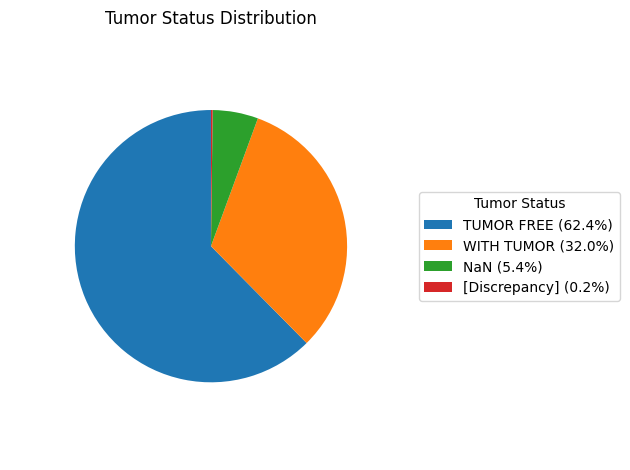

In [15]:
# Count and clean tumor status values
tumor_status_counts = metadata.tumor_status.dropna().value_counts()

# Create the pie chart
fig, ax = plt.subplots()
wedges, texts = ax.pie(
    tumor_status_counts,
    startangle=90
)

# Add legend with labels + percentages
percentages = (tumor_status_counts / tumor_status_counts.sum() * 100).round(1).astype(str) + '%'
labels_with_pct = [f"{label} ({pct})" for label, pct in zip(tumor_status_counts.index, percentages)]

ax.legend(wedges, labels_with_pct, title="Tumor Status", loc="center left", bbox_to_anchor=(1, 0.5))
ax.set_title('Tumor Status Distribution')
ax.axis('equal')

plt.tight_layout()
plt.show()


In [16]:
pd.crosstab(metadata.tumor_status, metadata.vital_status)

vital_status,Alive,Dead
tumor_status,,
NaN,3,24
TUMOR FREE,250,62
WITH TUMOR,31,129
[Discrepancy],0,1


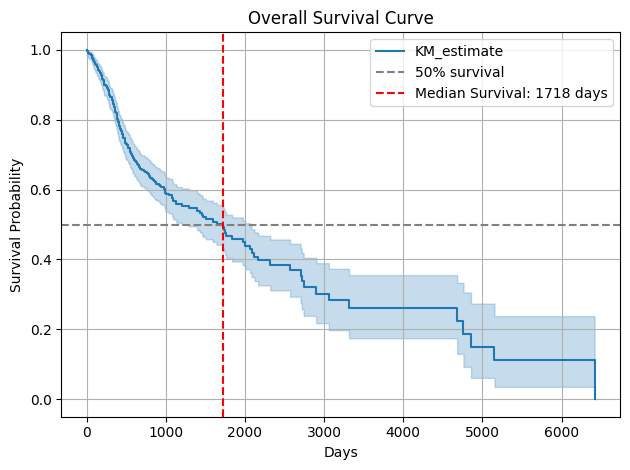

In [18]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

# Fit KM model
kmf = KaplanMeierFitter()
kmf.fit(durations=metadata['OS.time'], event_observed=metadata['OS'])

# Get median survival time
median_survival = kmf.median_survival_time_

# Get survival probability at 5 years (1825 days)
surv_5yr = kmf.predict(1825)

# Plot survival function
ax = kmf.plot_survival_function()
plt.title('Overall Survival Curve')
plt.xlabel('Days')
plt.ylabel('Survival Probability')

# Add horizontal line at 0.5 and vertical line at median survival
plt.axhline(0.5, color='gray', linestyle='--', label='50% survival')
plt.axvline(median_survival, color='red', linestyle='--', label=f'Median Survival: {int(median_survival)} days')

# Annotate plateau if curve flattens at the end
if kmf.survival_function_.iloc[-1, 0] > 0.0:
    plt.annotate('Plateau (long-term survivors)',
                 xy=(kmf.survival_function_.index[-1], kmf.survival_function_.iloc[-1, 0]),
                 xytext=(kmf.survival_function_.index[-1]*0.8, 0.2),
                 arrowprops=dict(arrowstyle='->'))



plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
import pandas as pd
import numpy as np

# Get survival function
surv_func = kmf.survival_function_.copy()
surv_func['days'] = surv_func.index
surv_func['years'] = (surv_func['days'] / 365).astype(int)

# Compute survival at each year boundary
surv_by_year = surv_func.groupby('years')['KM_estimate'].first()

# Compute survival drop per year
yearly_drop = surv_by_year.diff(periods=-1)  # drop from current to next year
steepest_year = yearly_drop.idxmax()

print(f"Steepest decline in survival occurred between year {steepest_year} and {steepest_year + 1}.")
print(yearly_drop)


Steepest decline in survival occurred between year 0 and 1.
years
0     0.178804
1     0.171752
2     0.082850
3     0.040040
4     0.068112
5     0.060987
6     0.012821
7     0.102031
8     0.021739
9     0.000000
10    0.000000
11    0.037266
12    0.037266
13    0.074533
14    0.000000
15    0.111799
17         NaN
Name: KM_estimate, dtype: float64
